# Load packages

In [3]:
import pandas as pd
import numpy as np 
import os
from pprint import pprint
import matplotlib.pyplot as plt
import copy


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

os.chdir(r'C:\Users\mkommaraju\OneDrive - PayPal\MyDocuments_from_Laptop\Work\ML\NLP_Showcase')
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Load data

In [4]:
df_train_validate = pd.read_csv('train.csv')
df_test           = pd.read_csv('test.csv')

df_train_validate = df_train_validate.loc[:1000]
df_test = df_test.loc[:1000]

df_train_validate.columns
df_train_validate['ABSTRACT'].head()

from sklearn.model_selection import train_test_split
df_train, df_validate = train_test_split(df_train_validate, test_size = 0.2)

df_train.reset_index(inplace=True)
df_validate.reset_index(inplace=True)
df_test.reset_index(inplace=True)

X_train = df_train['ABSTRACT']
Y_train = df_train[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']]

X_validate = df_validate['ABSTRACT']
Y_validate = df_validate[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']]

X_test = df_test['ABSTRACT']


# Pre-process text

In [5]:
import custom_preprocessing as cp
def my_custom_preprocessing(texts):
    texts= cp.my_simple_preprocessing(texts)
    texts = [w for w in cp.sent_to_words(texts)] 
    texts = cp.lemmatization(texts)
    texts = cp.remove_stopwords(texts)
    return texts

docs_train    = my_custom_preprocessing(X_train)
docs_validate = my_custom_preprocessing(X_validate)
docs_test     = my_custom_preprocessing(X_test)



import gensim.corpora as corpora   
import gensim
id2word = corpora.Dictionary(docs_train)
id2word.filter_extremes(no_below=10, keep_n=10000)
print('id2word length:' + str(len(id2word)))

# build the TFIDF model
tfidf_model = gensim.models.TfidfModel([id2word.doc2bow(text) for text in docs_train], id2word=id2word)

# build the corpus for train, validate and test data
corpus_train    = [id2word.doc2bow(text) for text in docs_train]
corpus_validate = [id2word.doc2bow(text) for text in docs_validate]
corpus_test     = [id2word.doc2bow(text) for text in docs_test]

# Build TF-IDF corpus for the train, validate and test data
corpus_tfidf_train    = tfidf_model[corpus_train]
corpus_tfidf_validate = tfidf_model[corpus_validate]
corpus_tfidf_test     = tfidf_model[corpus_test]

# build the X vectors for train, validate and test data
X_train_corpus_df       = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_train     , len(id2word.keys()) ).T, columns = list(id2word.values()))
X_validate_corpus_df    = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_validate  , len(id2word.keys()) ).T, columns = list(id2word.values()))
X_test_corpus_df        = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_test      , len(id2word.keys()) ).T, columns = list(id2word.values()))

# build the TFIDF X vectors for train, validate and test data
X_train_corpus_tfidf_df    = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_tfidf_train   , len(id2word.keys()) ).T, columns = list(id2word.values()))
X_validate_corpus_tfidf_df = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_tfidf_validate, len(id2word.keys()) ).T, columns = list(id2word.values()))
X_test_corpus_tfidf_df     = pd.DataFrame(data = gensim.matutils.corpus2dense(corpus_tfidf_test    , len(id2word.keys()) ).T, columns = list(id2word.values()))


C:\Users\mkommaraju\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


id2word length:783


## check data

In [6]:
i=0
print(X_train[i])
print(docs_train[i])
[(id2word[id], freq) for id, freq in corpus_train[i]]
[(id2word[id], round(freq,2)) for id, freq in corpus_tfidf_train[i]]
Y_train.loc[i]
 
# columns/terms in the dictionary, top 20 words in the corpus
X_train_corpus_df.columns
X_train_corpus_df.mean(axis=0).sort_values(ascending =False).head(20)

  Dependently typed languages such as Coq are used to specify and verify the
full functional correctness of source programs. Type-preserving compilation can
be used to preserve these specifications and proofs of correctness through
compilation into the generated target-language programs. Unfortunately,
type-preserving compilation of dependent types is hard. In essence, the problem
is that dependent type systems are designed around high-level compositional
abstractions to decide type checking, but compilation interferes with the
type-system rules for reasoning about run-time terms.
We develop a type-preserving closure-conversion translation from the Calculus
of Constructions (CC) with strong dependent pairs ($\Sigma$ types)---a subset
of the core language of Coq---to a type-safe, dependently typed compiler
intermediate language named CC-CC. The central challenge in this work is how to
translate the source type-system rules for reasoning about functions into
target type-system rules for 

model        0.81875
use          0.77500
result       0.54375
show         0.53750
method       0.52250
network      0.51125
datum        0.46250
system       0.44750
base         0.44125
propose      0.43375
study        0.37500
time         0.37000
state        0.35250
problem      0.35250
algorithm    0.34500
paper        0.30625
approach     0.30250
present      0.26750
provide      0.25750
function     0.25750
dtype: float32

## Classification

In [7]:
X = X_train_corpus_tfidf_df
Y = Y_train

Xv = X_validate_corpus_tfidf_df
Yv = Y_validate

############################################################
# Multi-label random forest
############################################################

colormap = plt.cm.jet(np.linspace(0,1,Y.shape[1]))

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

rfc = RandomForestClassifier(random_state=0, class_weight='balanced', verbose=1)

# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#rfc_grid_param = {'n_estimators': [10,50,100,500],'criterion': ['entropy'],'bootstrap': [True]} # max_features, max_depth, max_leaf_nodes 
rfc_grid_param = {'n_estimators': [100],'criterion': ['entropy'],'bootstrap': [True]} # max_features, max_depth, max_leaf_nodes 
rfc_gd_sr = GridSearchCV(estimator=rfc, param_grid=rfc_grid_param, scoring='roc_auc', cv=3,n_jobs=1, refit =True, return_train_score = True)
rfc_gd_sr.fit(X=X, y=Y)
print(rfc_gd_sr.best_params_)
print(rfc_gd_sr.best_score_)  
print(rfc_gd_sr.cv_results_ )

rfc_gd_sr.cv_results_['mean_test_score']
rfc_gd_sr.cv_results_['rank_test_score']
rfc_gd_sr.cv_results_['std_test_score']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}
0.8169694160409767
{'mean_fit_time': array([2.37502368]), 'std_fit_time': array([0.0965519]), 'mean_score_time': array([0.12937061]), 'std_score_time': array([0.0087574]), 'param_bootstrap': masked_array(data=[True],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_criterion': masked_array(data=['entropy'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[100],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}], 'split0_test_score': array([0.84185707]), 'split1_test_score': array([0.83463834]), 'split2_test_score': array([0.77441284]), 'mean_test_score': array([0.81696942]), 'std_test_score': array([0.03023601]), 'rank_test_score': array([1]), 'split0_train_score': array([1.]), 'split1_train_score': array([1.]), 'split

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished


array([0.03023601])

0
1
2
3
4
5


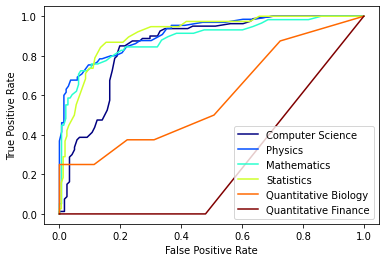

In [9]:
###########
# ROC & AUC 
###########

rfc = RandomForestClassifier(**rfc_gd_sr.best_params_)
#rfc = RandomForestClassifier(random_state=0, class_weight='balanced', verbose=1, n_estimators=100, criterion='entropy', bootstrap=True)
rfc.fit(X=X, y=Y)
Yv_p = rfc.predict_proba(Xv)
category_auc_rfc = []
Yv_category_prob = pd.DataFrame()
i=0
for i in range(Yv.shape[1]):
    print(i)
    Yv_category_prob[Yv.columns[i]] = copy.deepcopy(Yv_p[i][:,1])
    fpr, tpr, p_cutoff = metrics.roc_curve(Yv.iloc[:,i], Yv_p[i][:,1])
    category_auc_rfc.append(roc_auc_score(Yv.iloc[:,i], Yv_p[i][:,1]))
    plt.plot(fpr, tpr, color=colormap[i], label = Yv.columns[i]) 
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

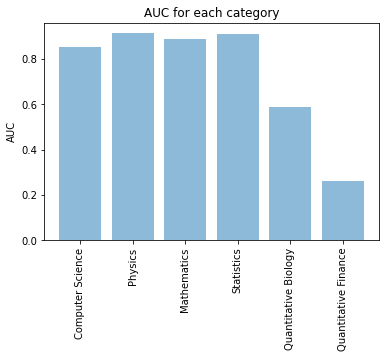

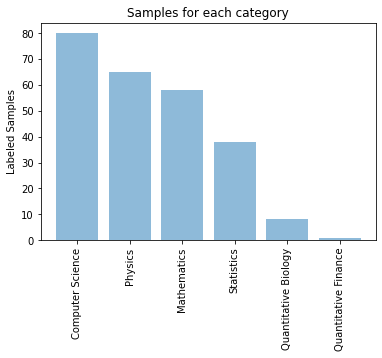

In [10]:
plt.bar(np.arange(len(Yv.columns)), category_auc_rfc, align='center', alpha=0.5)
plt.xticks(np.arange(len(Yv.columns)), Yv.columns)
plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('AUC for each category')
plt.show()

plt.bar(np.arange(len(Yv.columns)), Yv.sum(axis=0), align='center', alpha=0.5)
plt.xticks(np.arange(len(Yv.columns)), Yv.columns)
plt.xticks(rotation=90)
plt.ylabel('Labeled Samples')
plt.title('Samples for each category')
plt.show()

In [12]:
# Print feature importances
rfc_feature_imp = pd.DataFrame({'Feature': X.columns.values, 'Importance':rfc.feature_importances_}).sort_values('Importance', ascending = False)
print(rfc_feature_imp.head(20))

         Feature  Importance
79       propose    0.021087
180      network    0.019529
17         prove    0.018736
175        datum    0.014629
36        energy    0.013618
331    algorithm    0.013260
195        learn    0.012959
28           use    0.012890
10         model    0.011266
437  temperature    0.009684
243        paper    0.009496
54          base    0.009223
45        result    0.008105
179     learning    0.007842
132         show    0.007374
312       effect    0.007155
75   performance    0.006686
94         group    0.006292
14       problem    0.006131
357         task    0.006007


# Topic Modeling

n:2 i:0
n:2 i:1
n:2 i:2
n:2 i:3
n:2 i:4
n:3 i:0
n:3 i:1
n:3 i:2
n:3 i:3
n:3 i:4
n:4 i:0
n:4 i:1
n:4 i:2
n:4 i:3
n:4 i:4
n:5 i:0
n:5 i:1
n:5 i:2
n:5 i:3
n:5 i:4
n:6 i:0
n:6 i:1
n:6 i:2
n:6 i:3
n:6 i:4
n:7 i:0
n:7 i:1
n:7 i:2
n:7 i:3
n:7 i:4
n:8 i:0
n:8 i:1
n:8 i:2
n:8 i:3
n:8 i:4
n:9 i:0
n:9 i:1
n:9 i:2
n:9 i:3
n:9 i:4


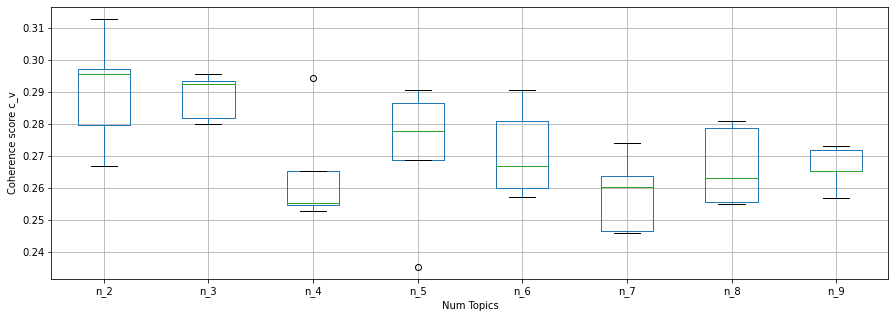

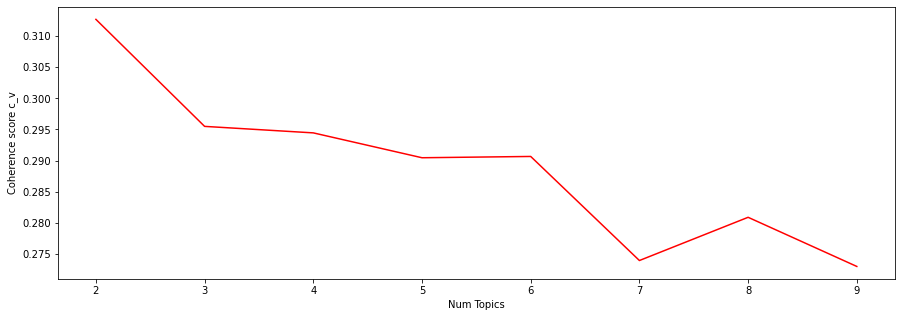

In [13]:
#################################
# Topic quality - coherence
#################################

corpus = corpus_tfidf_train
docs = docs_train
id2word = id2word

# https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

start=2; limit=10;  step=1;
models_per_level = 5
c_v    = []
model_list = []
random_seed_list = []
df_c_v = pd.DataFrame()
model_list_i = 0
model_list_index = []

#num_topics=4
for num_topics in range(start, limit, step):
    c = -float("inf")
    i_max = 0
    c_list = []
    i=0
    for i in range(models_per_level):
        print('n:'+str(num_topics)+' i:'+str(i))
        model_i = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics,alpha='auto',per_word_topics=False, minimum_probability=0, random_state=i)
        c_i = CoherenceModel(model=model_i, texts=docs, dictionary=id2word, coherence='c_v' , processes =1).get_coherence()
        c_list.append(c_i)
        if c_i>c:
            model = copy.deepcopy(model_i)
            c = c_i
            i_max = i
    c_v.append (c)
    model_list.append(model)
    model_list_index.append(model_list_i)
    model_list_i += 1
    random_seed_list.append(i_max)
    df_c_v["n_"+str(num_topics)] = c_list


plt.figure(figsize=(15,5))
df_c_v.boxplot()
plt.xlabel("Num Topics")
plt.ylabel("Coherence score c_v")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(range(start, limit, step), c_v,'r')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score c_v")
plt.show()


In [14]:
for i in range(0, len(model_list), 1):
    print("i:{0}, cv:{1}".format(i,c_v[i]))

# chose number of categories based on lowest coherence score
len(model_list)
i=4
c_v[i]
model = model_list[i]

i:0, cv:0.31266186148578234
i:1, cv:0.2954966086963466
i:2, cv:0.29445444729007125
i:3, cv:0.2904662531299949
i:4, cv:0.29067302951175233
i:5, cv:0.27398291681942655
i:6, cv:0.2809150241174493
i:7, cv:0.2730328026174551


## LDA Viz

In [19]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model, corpus, id2word, sort_topics=False)

C:\Users\mkommaraju\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_vis_'+str(model.num_topics)+'_topics.html')

C:\Users\mkommaraju\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
vis0 = vis[0] # topic	x	y	topics	cluster	Freq
vis1 = vis[1] # term	Category	Freq	Term	Total	loglift	logprob
vis2 = vis[2] # Topic, Freq, Term

C:\Users\mkommaraju\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Word Cloud

C:\Users\mkommaraju\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


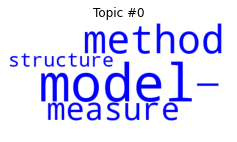

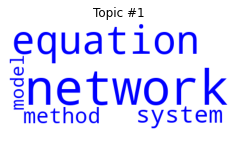

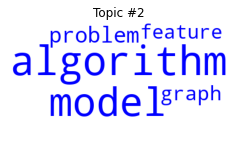

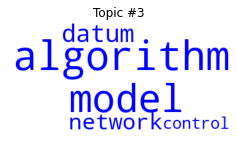

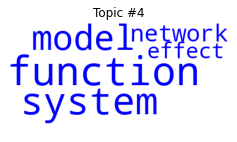

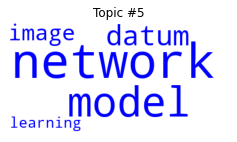

In [24]:
#https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud.fit_words
from wordcloud import WordCloud
w = WordCloud(background_color='white', relative_scaling=1, colormap ='tab10')
w = WordCloud(background_color='white', relative_scaling=1, color_func=lambda *args, **kwargs: (0,0,255))
for t in range(model.num_topics):
    plt.figure(figsize=(4,4))
    plt.imshow(w.fit_words(dict(model.show_topic(t, 5)) ))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

## Print Topics

In [25]:
model.print_topics()
from itertools import compress
topic_key_words = []
max_key_works = 7
for t in range(model.num_topics):
    ss = [s for s, v in model.show_topic(t, max_key_works) if s!='pron']
    vv = [v for s, v in model.show_topic(t, max_key_works) if s!='pron']
    cum_percentile = np.cumsum(vv)/sum(vv)
    key_words = ss[0]
    for i in list(range(1,len(ss),1)):
        if cum_percentile[i]<0.8:
            key_words = key_words + ' ' + ss[i]
#    topic_key_words.append(' '.join([s for s, v in model.show_topic(t, 5) if s!='pron'] ))
    topic_key_words.append(key_words)
pprint(topic_key_words)


['model method _ measure structure',
 'network equation system method model',
 'algorithm model problem graph feature',
 'algorithm model datum network control',
 'function system model network effect',
 'network model datum image learning']


C:\Users\mkommaraju\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
corpus_topics_df = pd.DataFrame(columns = topic_key_words)
for i, doc_topics in enumerate(list(model[corpus])):
    corpus_topics_df.loc[i] = np.round([p for t,p in doc_topics],2)

corpus_dominant_topic_df = pd.DataFrame({'Dominant Topic':corpus_topics_df.idxmax(axis=1), \
                                         'Dominant Topic Percent':corpus_topics_df.max(axis=1)})

C:\Users\mkommaraju\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Vizualize Topic Clusers using TSNE and UMAP

C:\Users\mkommaraju\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\mkommaraju\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `

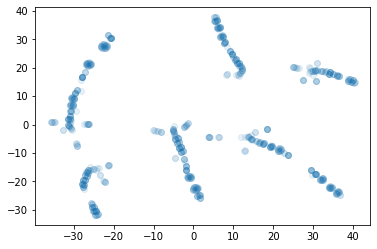

In [27]:
from sklearn.manifold import TSNE
topic_tsne_2d = TSNE(n_components=2, random_state=0).fit_transform(corpus_topics_df)
topic_tsne_2d_df = pd.DataFrame(data = topic_tsne_2d, columns = ['tsne_x','tsne_y'])
plt.scatter(topic_tsne_2d[:,0], topic_tsne_2d[:,1], alpha=0.1)
plt.show()

C:\Users\mkommaraju\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\types\__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for m

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\mkommaraju\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\mkommaraju\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\mkommaraju\Anaconda3\lib\site-packages\sklear

C:\Users\mkommaraju\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
C:\Users\mkommaraju\Anaconda3\lib\site-packages\numba\core\ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
C:\Users\mkommaraju\Anaconda3\lib\site-

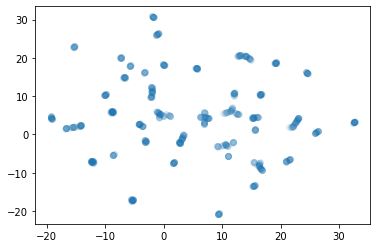

In [28]:
# https://stackoverflow.com/questions/57242208/how-to-resolve-the-error-module-umap-has-no-attribute-umap-i-tried-installi
#import umap
import umap.umap_ as umap
import matplotlib.cm as cm
umap_n = max(round(corpus_topics_df.shape[0]*0.01),5)
topic_umap_2d = umap.UMAP(n_neighbors=umap_n, min_dist=0.3, n_components=2).fit_transform(corpus_topics_df.values)
topic_umap_2d_df = pd.DataFrame(data = topic_umap_2d, columns = ['umap_x','umap_y'])
plt.scatter(topic_umap_2d[:,0], topic_umap_2d[:,1], alpha=0.1)
plt.show()

C:\Users\mkommaraju\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
